Authentication with EllipticManifold
===

Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate modeling with the EllipticManifold model.


In [projection methods](https://doi.org/10.1016/S0169-7439(02)00107-7) a dimensionality reduction is first performed to compress the data into a lower dimensional space; authentication can be performed by enveloping the projected points in an elliptical boundary.  The cutoff for this boundary can be determined using a Mahalanobis distance, for example.  DD-SIMCA uses a different statistical cutoff approach, but distance-based methods are common.
    
PCA and related approaches (e.g., SIMCA) perform linear dimensionality reduction.  This general authentication approach can be generalized by replacing the PCA with any non-linear dimensionality reduction step.  This is what the EllipticManifold model allows you to do; it is essentially the application of sklearn's [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) fitted around the training data after undergoing some kind of dimensionality reduction.  It assumes the data follows a Gaussian distribution in the lower dimensional space.

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !pip install git+https://github.com/mahynski/pychemauth@main

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import imblearn
import numpy as np
import sklearn.decomposition
import sklearn.manifold

from sklearn.model_selection import GridSearchCV

from pychemauth.manifold.elliptic import EllipticManifold_Model

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.7.2
imblearn  : 0.11.0
pychemauth: 0.0.0b3
watermark : 2.4.3
sklearn   : 1.3.0
json      : 2.0.9
numpy     : 1.24.4



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica'])) 
y = y.apply(lambda x: names[x])

In [6]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
from sklearn.model_selection import train_test_split
from pychemauth.preprocessing.scaling import CorrectedScaler

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=0,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

# Normally we would include this in a pipeline, but for these examples we will just do this ahead of time.
scaler = CorrectedScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Principal Components Analysis
---

We do not need to use a non-linear DR method.  As a first example, let's use PCA.


In [8]:
# If more than 1 class is used during training an exception is thrown
setosa = EllipticManifold_Model(
    alpha=0.05, 
    dr_model=sklearn.decomposition.PCA, # A linear approach
    kwargs={'n_components':2}, # Keywords for the dr_model
    ndims='n_components', # The keyword that corresponds to the dimensionality of space
    robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
    center='score' # Center the ellipse around the emperical mean of the projected data
)

_ = setosa.fit(
    X_train[y_train == 'setosa'], 
    y_train[y_train == 'setosa']
)

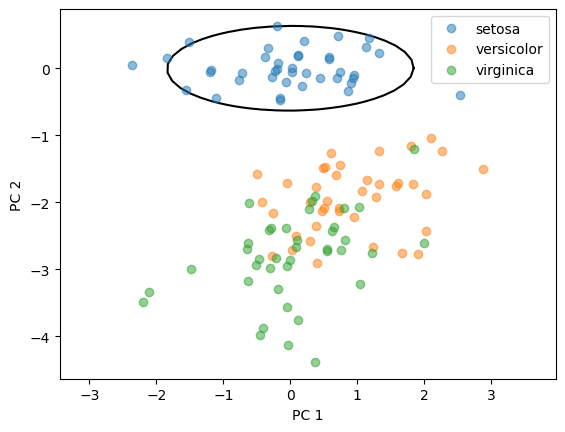

In [9]:
_ = setosa.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

In [10]:
# Predict how many training examples are considered inliers
setosa.predict(X_train[y_train == 'setosa'])

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [11]:
# Predict if the other classes are considered inliers
setosa.predict(X_train[y_train != 'setosa'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

<Axes: xlabel='Expected', ylabel='Observed'>

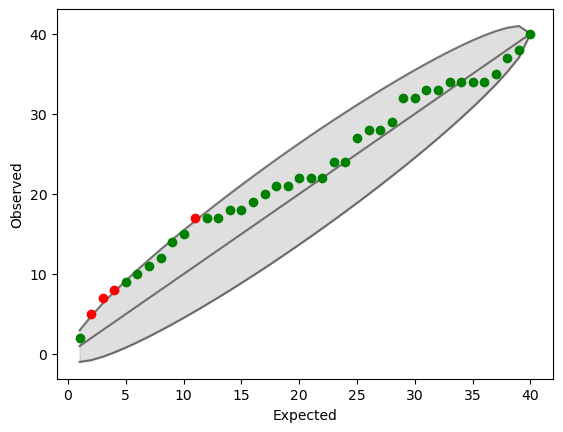

In [12]:
# The extremes plot helps you understand how Gaussian the data in the reduced dimensionality space
setosa.extremes_plot(X_train[y_train == 'setosa'], upper_frac=1.0)

Kernel PCA
---

PCA can be made non-linear by switching to kernel PCA. See [scikit-learn's documentation](https://scikit-learn.org/stable/modules/decomposition.html#kernel-pca) for details on hyperparameters.


In [13]:
setosa = EllipticManifold_Model(
    alpha=0.05, 
    dr_model=sklearn.decomposition.KernelPCA, 
    kwargs={'n_components': 2, 'kernel': 'cosine'}, 
    ndims='n_components', 
    robust=True, 
    center='score' 
)

_ = setosa.fit(
    X_train[y_train == 'setosa'], 
    y_train[y_train == 'setosa']
)

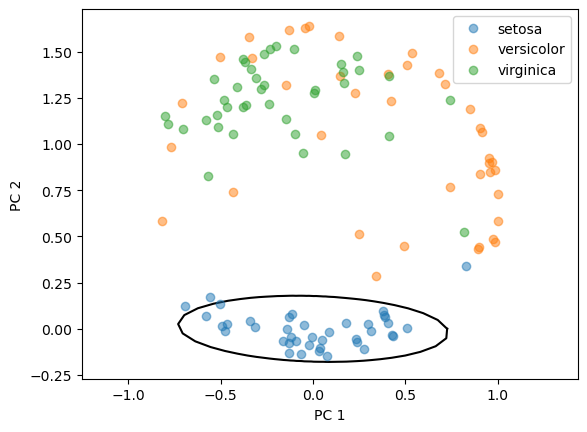

In [14]:
_ = setosa.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

<Axes: xlabel='Expected', ylabel='Observed'>

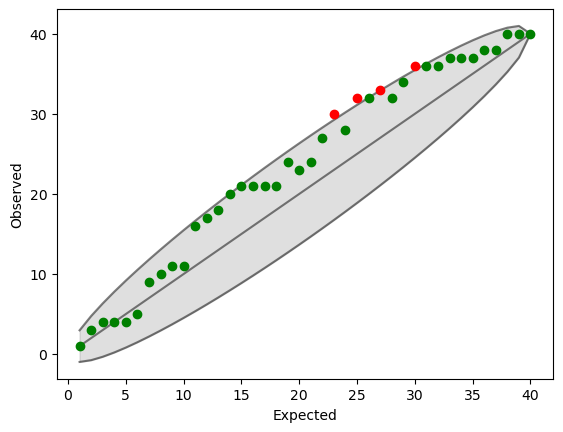

In [15]:
setosa.extremes_plot(X_train[y_train == 'setosa'], upper_frac=1.0)

Isometric Mapping
---

Isometric mapping is another non-linear DR approach.  You can read more in [scikit-learn's documentation](https://scikit-learn.org/stable/modules/manifold.html#isomap).


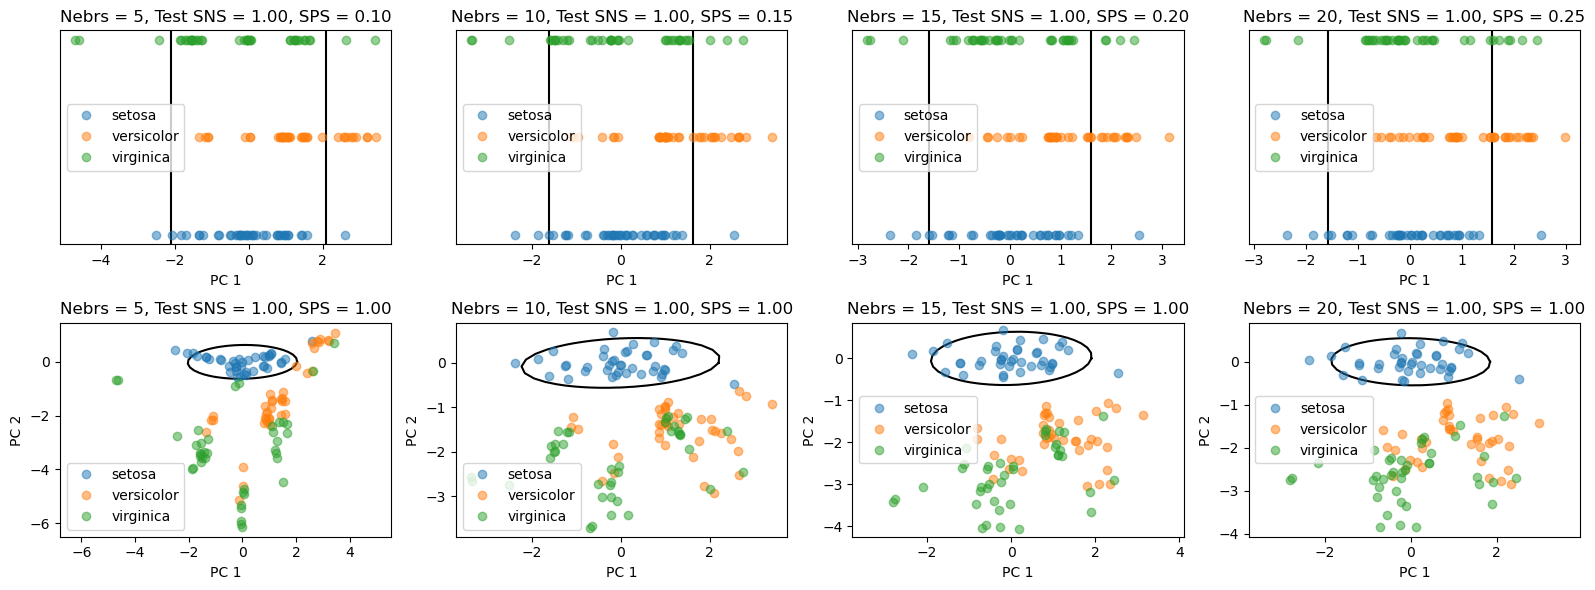

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 15, 20]:
        setosa = EllipticManifold_Model(
            alpha=0.05, 
            dr_model=sklearn.manifold.Isomap, 
            kwargs={"n_components": dims, "metric":'minkowski', "p":2, "n_neighbors":nebrs}, 
            ndims="n_components", 
            robust=True, 
            center='score' 
        )
        _ = setosa.fit(X_train[y_train == 'setosa'])
        
        _ = setosa.visualize(
            [
                X_train[y_train == 'setosa'],
                X_train[y_train == 'versicolor'],
                X_train[y_train == 'virginica']
            ], 
            ['setosa', 'versicolor', 'virginica'],
            ax=ax[idx]
        )
        
        test_sns = np.sum(setosa.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
        test_sps = 1.0 - np.sum(setosa.predict(X_test[y_test != 'setosa'])) / np.sum(y_test != 'setosa')

        ax[idx].set_title('Nebrs = {}, Test SNS = {}, SPS = {}'.format(nebrs, '%.2f'%test_sns, '%.2f'%test_sps))
        idx += 1
plt.tight_layout()

Locally Linear Embedding
---

Locally linear embedding mapping is another non-linear DR approach.  You can read more in [scikit-learn's documentation](https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding).


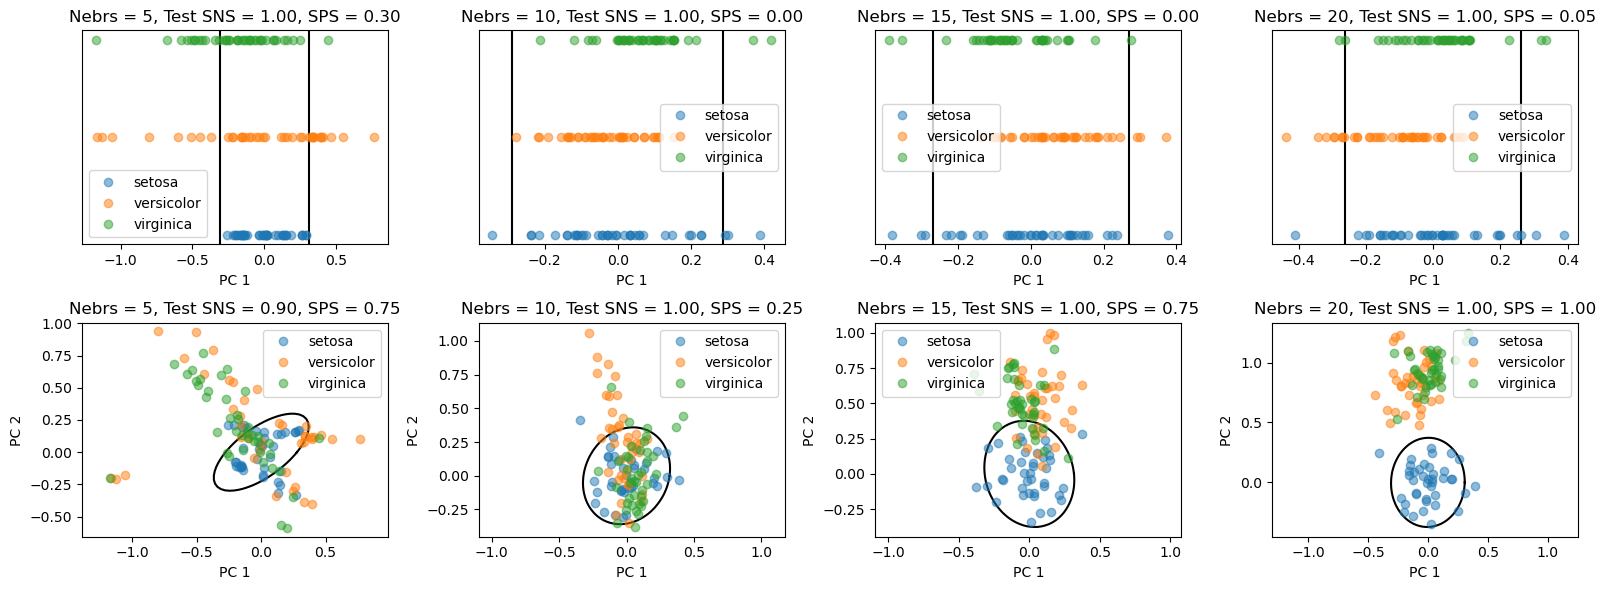

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 15, 20]:
        setosa = EllipticManifold_Model(
            alpha=0.05, 
            dr_model=sklearn.manifold.LocallyLinearEmbedding, 
            kwargs={"n_components": dims, "n_neighbors":nebrs}, 
            ndims="n_components", 
            robust=True, 
            center='score' 
        )
        _ = setosa.fit(X_train[y_train == 'setosa'])
        
        _ = setosa.visualize(
            [
                X_train[y_train == 'setosa'],
                X_train[y_train == 'versicolor'],
                X_train[y_train == 'virginica']
            ], 
            ['setosa', 'versicolor', 'virginica'],
            ax=ax[idx]
        )
        
        test_sns = np.sum(setosa.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
        test_sps = 1.0 - np.sum(setosa.predict(X_test[y_test != 'setosa'])) / np.sum(y_test != 'setosa')

        ax[idx].set_title('Nebrs = {}, Test SNS = {}, SPS = {}'.format(nebrs, '%.2f'%test_sns, '%.2f'%test_sps))
        idx += 1
plt.tight_layout()

UMAP Example
---

UMAP has a lot of parameters that should be understood before using it.  See the [documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html) for explanation. Briefly, there are 4 that matter the most:

* n_neighbors
* n_components
* metric
* min_dist

**IMPORTANTLY** you should always set random_state to ensure reproducibility between runs since UMAP is stochastic.

In [18]:
import umap

/home/nam4/anaconda3/envs/oyster-provenance/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nam4/anaconda3/envs/oyster-provenance/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nam4/anaconda3/envs/oyster-provenance/lib/pyth

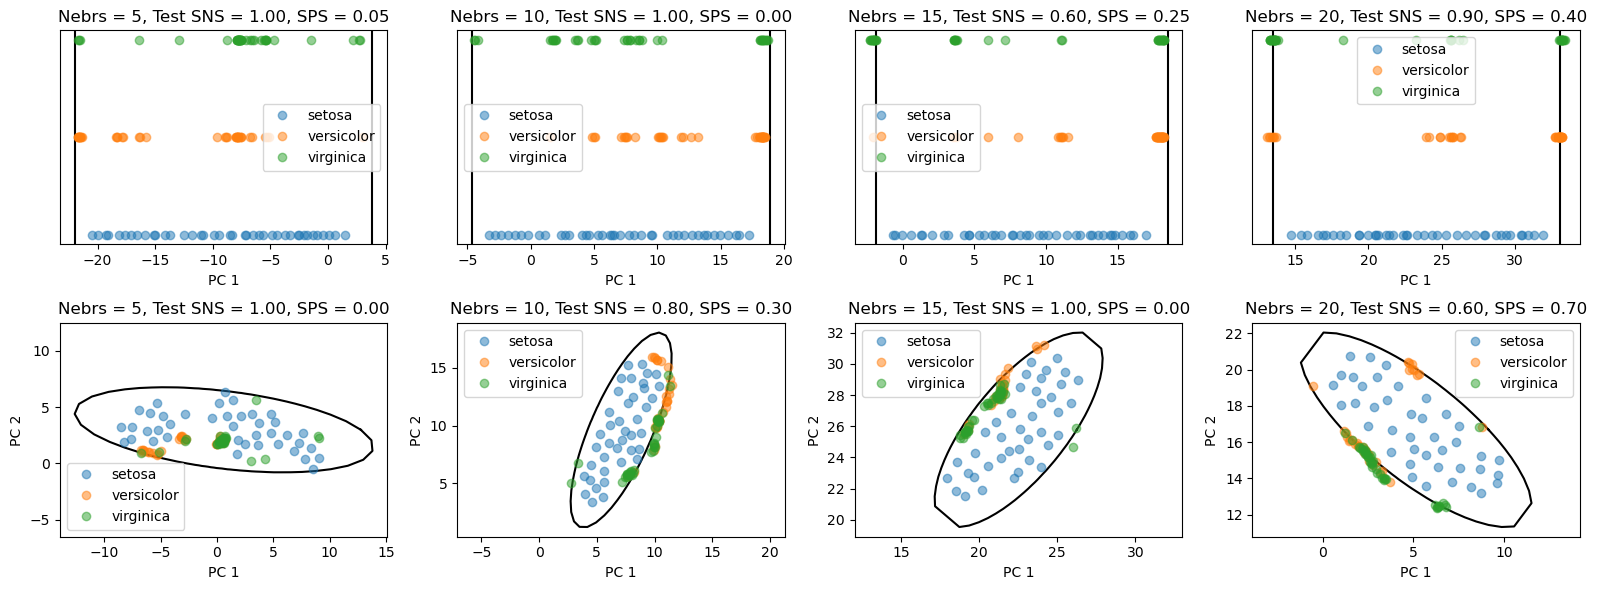

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    for nebrs in [5, 10, 15, 20]:
        setosa = EllipticManifold_Model(
            alpha=0.05, 
            dr_model=umap.UMAP, 
            kwargs={
                "n_components": dims, 
                "n_neighbors": nebrs, 
                "random_state": 0, # Always set this for reproducibility
                "metric": "euclidean",
                "min_dist": 1.0
            }, 
            ndims="n_components", 
            robust=True, 
            center='score' 
        )
        _ = setosa.fit(X_train[y_train == 'setosa'])
        
        _ = setosa.visualize(
            [
                X_train[y_train == 'setosa'],
                X_train[y_train == 'versicolor'],
                X_train[y_train == 'virginica']
            ], 
            ['setosa', 'versicolor', 'virginica'],
            ax=ax[idx]
        )
        
        test_sns = np.sum(setosa.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
        test_sps = 1.0 - np.sum(setosa.predict(X_test[y_test != 'setosa'])) / np.sum(y_test != 'setosa')

        ax[idx].set_title('Nebrs = {}, Test SNS = {}, SPS = {}'.format(nebrs, '%.2f'%test_sns, '%.2f'%test_sps))
        idx += 1
plt.tight_layout()

Building an Authenticator
---

In training loops and other applications it is convenient to not have to separate classes for training.  This is one thing that EllipticManifold_Authenticator conveniently does for you, which is illustrated below.  Here, we simply specify the class we care about and all others are automatically ignored like we did manually above.  

Another factor we need to consider is that there are 2 ways to train an authentication model [1].  A "rigorous" approach would be to train a model considering only the true examples of a known class.  We could select a desired `alpha` value and adjust `n_components` to try to achieve this, since it is the desired type I error rate.  This is essentially like setting the accuracy for true positives (TSNS), while ignoring the behavior with respect to alternative classes.  

Alternatively, we could use examples of alternatives and adjust our hyperparameters to optimize an overall metric like total efficiency (TEFF) which considers how often we get true positives correct (TSNS) and how often we correctly reject the true negatives (TSPS). This is a "compliant" approach. These sorts of models use more information and might seem more performant, but this data is always biased by the set of known alternatives we use.  Since there are an infinite number of inauthentic things, this introduces some bias which can be difficult to quantify.

[[1] "Rigorous and compliant approaches to one-class classification," Rodionova, O., Oliveri, P., and Pomerantsev, A. Chem. and Intell. Lab. Sys. (2016) 89-96.](https://doi.org/10.1016/j.chemolab.2016.10.002)
 

In [20]:
from pychemauth.manifold.elliptic import EllipticManifold_Authenticator

In [21]:
# First let's consider a compliant model
compliant = EllipticManifold_Authenticator(
    alpha=0.05, 
    dr_model=sklearn.decomposition.PCA, # A linear approach
    kwargs={'n_components':2}, # Keywords for the dr_model
    ndims='n_components', # The keyword that corresponds to the dimensionality of space
    robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
    center='score', # Center the ellipse around the emperical mean of the projected data
    target_class='setosa', # Tell the classifier which class to use
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

In [22]:
# Note that y_train should contain examples of the target_class or else an exception will be thrown.  Otherwise,
# all other classes will be used by the model to optimize TEFF
_ = compliant.fit(X_train, y_train)

In [23]:
compliant.metrics(X_train, y_train)

{'teff': 0.9082951062292475,
 'tsns': 0.825,
 'tsps': 1.0,
 'csps': {'versicolor': 1.0, 'virginica': 1.0}}

In [24]:
# Now consider a rigorous model
rigorous = EllipticManifold_Authenticator(
    alpha=0.05, 
    dr_model=sklearn.decomposition.PCA, # A linear approach
    kwargs={'n_components':2}, # Keywords for the dr_model
    ndims='n_components', # The keyword that corresponds to the dimensionality of space
    robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
    center='score', # Center the ellipse around the emperical mean of the projected data
    target_class='setosa', # Tell the classifier which class to use
    use='rigorous' # Using a compliant approach will use the other classes provided at training time
)

In [25]:
_ = rigorous.fit(X_train, y_train)

In [26]:
rigorous.metrics(X_train, y_train)

{'teff': 0.9354143466934853,
 'tsns': 0.875,
 'tsps': 1.0,
 'csps': {'versicolor': 1.0, 'virginica': 1.0}}

The metrics are identical!  This is because the choice of rigorous vs. compliant has nothing to do with the <b>training</b> of the model.  This is important when we <b>optimize</b> the model since it determines what the optimal model looks like; i.e., should it be the one with the TSNS ~ 1-alpha, or the one with the best TEFF?


In [27]:
# The compliant model's score is the TEFF.
compliant.score(X_train, y_train)

0.9082951062292475

In [28]:
# We score a rigorous model as -(TSNS - (1-alpha))^2, so that a higher score is better (least negative) and a score of 
# 0 corresponds to hitting the target exactly.
rigorous.score(X_train, y_train)

-0.005624999999999994

Optimizing the Authenticator
---

<h3>Compliant Model</h3>

In [29]:
compliant_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("model", EllipticManifold_Authenticator(
            alpha=0.05, 
            dr_model=sklearn.decomposition.PCA, # A linear approach
            kwargs={'n_components':1}, # Keywords for the dr_model
            ndims='n_components', # The keyword that corresponds to the dimensionality of space
            robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
            center='score', # Center the ellipse around the emperical mean of the projected data
            target_class='setosa', # Tell the classifier which class to use
            use='compliant' # Using a compliant approach will use the other classes provided at training time
        )
    )
])

param_grid = [{
    'model__kwargs':[{'n_components':i} for i in [1, 2, 3, 4]],
}]

gs = GridSearchCV(
    estimator=compliant_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [30]:
gs.best_params_

{'model__kwargs': {'n_components': 2}}

In [31]:
print("Test set TEFF = {}; training set TEFF = {}".format(
    '%.3f'%(gs.score(X_test, y_test)),
    '%.3f'%(gs.score(X_train, y_train)),
    )
)

Test set TEFF = 1.000; training set TEFF = 0.908


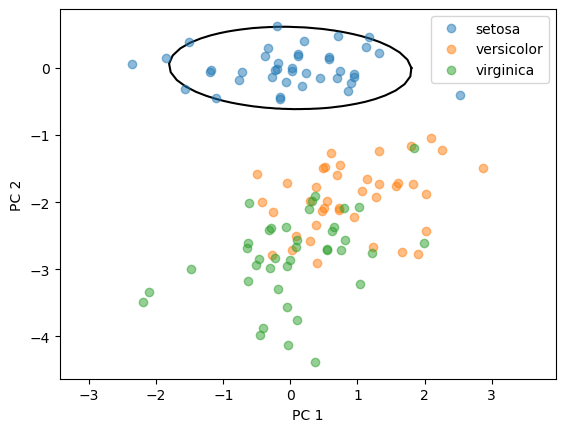

In [32]:
_ = gs.best_estimator_["model"].model.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

In [33]:
gs.best_estimator_["model"].metrics(X_train, y_train)

{'teff': 0.9082951062292475,
 'tsns': 0.825,
 'tsps': 1.0,
 'csps': {'versicolor': 1.0, 'virginica': 1.0}}

In [34]:
gs.best_estimator_["model"].metrics(X_test, y_test)

{'teff': 1.0,
 'tsns': 1.0,
 'tsps': 1.0,
 'csps': {'versicolor': 1.0, 'virginica': 1.0}}

<h3>Rigorous Model</h3>

In [35]:
rigorous_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("model", EllipticManifold_Authenticator(
            alpha=0.05, 
            dr_model=sklearn.decomposition.PCA, # A linear approach
            kwargs={'n_components':1}, # Keywords for the dr_model
            ndims='n_components', # The keyword that corresponds to the dimensionality of space
            robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
            center='score', # Center the ellipse around the emperical mean of the projected data
            target_class='setosa', # Tell the classifier which class to use
            use='rigorous' # Using a rigorous approach will use the other classes provided at training time
        )
    )
])

param_grid = [{
    'model__kwargs':[{'n_components':i} for i in [1, 2, 3, 4]],
}]

gs = GridSearchCV(
    estimator=rigorous_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [36]:
gs.best_params_

{'model__kwargs': {'n_components': 1}}

In [37]:
print("Test set TEFF = {}; training set TEFF = {}".format(
    '%.4f'%(gs.score(X_test, y_test)),
    '%.4f'%(gs.score(X_train, y_train)),
    )
)

Test set TEFF = -0.0025; training set TEFF = -0.0025


In [38]:
# We can manually compute these scores
tsns_test = np.sum(gs.predict(X_test[y_test == 'setosa'])) / np.sum(y_test == 'setosa')
(tsns_test - (1.0 - 0.05))**2

0.0025000000000000044

In [39]:
# We can manually compute these scores
tsns_train = np.sum(gs.predict(X_train[y_train == 'setosa'])) / np.sum(y_train == 'setosa')
(tsns_train - (1.0 - 0.05))**2

0.0024999999999999935

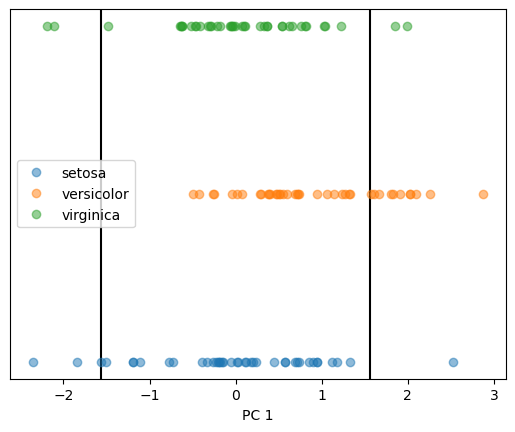

In [40]:
_ = gs.best_estimator_["model"].model.visualize(
    [
        X_train[y_train == 'setosa'],
        X_train[y_train == 'versicolor'],
        X_train[y_train == 'virginica']
    ], 
    ['setosa', 'versicolor', 'virginica']
)

In [41]:
gs.best_estimator_["model"].metrics(X_train, y_train)

{'teff': 0.4107919181288746,
 'tsns': 0.9,
 'tsps': 0.1875,
 'csps': {'versicolor': 0.275, 'virginica': 0.09999999999999998}}

In [42]:
gs.best_estimator_["model"].metrics(X_test, y_test)

{'teff': 0.22360679774997907,
 'tsns': 1.0,
 'tsps': 0.050000000000000044,
 'csps': {'versicolor': 0.09999999999999998, 'virginica': 0.0}}